## Dependencies

In [228]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [229]:
%matplotlib inline

In [230]:


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Summary:

In [231]:
# from IPython.display import Image
# Image("/Users/thakm004/Documents/Spotify/process_2.png")

## 1. Data Exploration/Preparation

\

In [232]:
spotify_df = pd.read_csv('D:\YASH\yash py\project\data.csv')

In [233]:
spotify_df.head()

valence  year  acousticness   
0   0.0594  1921         0.982  \
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability   
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279  \
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness   
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000  \
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode   
0   10     0.665   -20.096     1  \
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date   
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921  \
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful needed to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [234]:
data_w_genre = pd.read_csv('D:\YASH\yash py\project\data_w_genres.csv')
data_w_genre.head()

genres                                            artists   
0  ['show tunes']                   "Cats" 1981 Original London Cast  \
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness   
0      0.590111      0.467222  250318.555556  0.394003          0.011400  \
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key   
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5  \
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [235]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

This checks whether or not `genres` is actually in a list format:

In [236]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [237]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [238]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [239]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Voila, now we have the genre column in a format we can actually use.

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset



extracting the artists from the string list. 

In [240]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [241]:
spotify_df['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [242]:
spotify_df['artists_upd_v1'].values[0][0]

'Sergei Rachmaninoff'

every artist string format.... double check

In [243]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

valence  year  acousticness                             artists   
143    0.300  1921         0.772                ["Scarlet D'Carpio"]  \
234    0.902  1923         0.994  ["King Oliver's Creole Jazz Band"]   
238    0.554  1923         0.996  ["King Oliver's Creole Jazz Band"]   
244    0.319  1923         0.995    ["Clarence Williams' Blue Five"]   
249    0.753  1923         0.994  ["King Oliver's Creole Jazz Band"]   

     danceability  duration_ms  energy  explicit                      id   
143         0.560       249370   0.313         0  7b4eHImKQ51DYaQvNTdtEp  \
234         0.708       194533   0.361         0  1xEEYhWxT4WhDQdxfPCT8D   
238         0.546       170827   0.189         0  3rauXVLOOM5BlxWqUcDpkg   
244         0.520       197493   0.153         0  1UdqHVRFYMZKU2Q7xkLtYc   
249         0.359       187227   0.357         0  5SvyP1ZeJX1jA7AOZD08NA   

     instrumentalness  key  liveness  loudness  mode                     name   
143          0.000005    6     0.115    -8.346     0  Himno Nacional del Perú  \
234          0.883000    0     0.103   -11.764     0                Snake Rag   
238          0.908000    0     0.339   -15.984     1             Chimes Blues   
244          0.131000    0     0.353   -14.042     1     Pickin' On Your Baby   
249          0.819000    3     0.290   -11.810     1                    Tears   

     popularity release_date  speechiness    tempo artists_upd_v1  
143           0   1921-09-23       0.0376  107.501             []  
234          20         1923       0.0441  105.695             []  
238          13         1923       0.0581   80.318             []  
244          11         1923       0.0440  102.937             []  
249          10         1923       0.0511  205.053             []

So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [244]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [245]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [246]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [247]:
spotify_df[spotify_df['name']=='Adore You']

valence  year  acousticness           artists  danceability   
19425    0.569  2019        0.0237  ['Harry Styles']         0.676  \
38319    0.569  2019        0.0237  ['Harry Styles']         0.676   

       duration_ms  energy  explicit                      id   
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7  \
38319       207133   0.771         0  1M4qEo4HE3PRaCOM7EXNJq   

       instrumentalness  ...  mode       name  popularity  release_date   
19425          0.000007  ...     1  Adore You          88    2019-12-13  \
38319          0.000007  ...     1  Adore You          77    2019-12-06   

      speechiness   tempo  artists_upd_v1  artists_upd_v2     artists_upd   
19425      0.0483  99.048  [Harry Styles]              []  [Harry Styles]  \
38319      0.0483  99.048  [Harry Styles]              []  [Harry Styles]   

                artists_song  
19425  Harry StylesAdore You  
38319  Harry StylesAdore You  

[2 rows x 23 columns]

In [248]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [249]:
spotify_df[spotify_df['name']=='Adore You']

valence  year  acousticness           artists  danceability   
19425    0.569  2019        0.0237  ['Harry Styles']         0.676  \

       duration_ms  energy  explicit                      id   
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7  \

       instrumentalness  ...  mode       name  popularity  release_date   
19425          0.000007  ...     1  Adore You          88    2019-12-13  \

      speechiness   tempo  artists_upd_v1  artists_upd_v2     artists_upd   
19425      0.0483  99.048  [Harry Styles]              []  [Harry Styles]  \

                artists_song  
19425  Harry StylesAdore You  

[1 rows x 23 columns]

Now I can explode this column and merge as I planned to in `Step 2`
![Alt text](image.png)

In [250]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [251]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [252]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

Empty DataFrame
Columns: [artists_upd, id, genres, artists, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence, popularity, key, mode, count, genres_upd]
Index: []

Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [253]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [254]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [255]:
artists_genres_consolidated.head()

id                                         genres_upd   
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_wave, new_wave_po...  \
1  000GyYHG4uWmlXieKLij8u  [[alternative_hip_hop, conscious_hip_hop, minn...   
2  000Npgk5e2SgwGaIsN3ztv  [[classic_bollywood, classic_pakistani_pop, fi...   
3  000ZxLGm7jDlWCHtcXSeBe    [[boogie-woogie, piano_blues, ragtime, stride]]   
4  000jBcNljWTnyjB4YO7ojf                                               [[]]   

                            consolidates_genre_lists  
0  [rock, candy_pop, new_wave_pop, permanent_wave...  
1  [minnesota_hip_hop, pop_rap, conscious_hip_hop...  
2  [filmi, ghazal, classic_bollywood, sufi, class...  
3      [boogie-woogie, piano_blues, stride, ragtime]  
4                                                 []

In [256]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
![Alt text](image-1.png)
### - Create TF-IDF features off of artist genres
As we can see, TF-IDF can be a very handy metric for determining how important a term is in a document. But how is TF-IDF used? There are three main applications for TF-IDF. These are in machine learning, information retrieval, and text summarization/keyword extraction.

Using TF-IDF in machine learning & natural language processing
Machine learning algorithms often use numerical data, so when dealing with textual data or any natural language processing (NLP) task, a sub-field of ML/AI dealing with text, that data first needs to be converted to a vector of numerical data by a process known as vectorization. TF-IDF vectorization involves calculating the TF-IDF score for every word in your corpus relative to that document and then putting that information into a vector (see image below using example documents “A” and “B”). Thus each document in your corpus would have its own vector, and the vector would have a TF-IDF score for every single word in the entire collection of documents. Once you have these vectors you can apply them to various use cases such as seeing if two documents are similar by comparing their TF-IDF vector using cosine similarity.
![Alt text](image-2.png)

In [257]:
spotify_df.tail()

valence  year  acousticness   
156602    0.768  1997        0.2820  \
156603    0.792  2004        0.0248   
156604    0.697  1999        0.0516   
156605    0.429  1994        0.0249   
156606    0.273  1996        0.0113   

                                               artists  danceability   
156602                      ["Lil' Kim", "Lil' Cease"]         0.748  \
156603                            ["Lil' Flip", 'Lea']         0.814   
156604  ["Ol' Dirty Bastard", 'Kelis', 'Rich Travali']         0.934   
156605      ["World Class Wreckin' Cru", "Michel 'Le"]         0.715   
156606      ["Rappin' 4-Tay", 'MC Breed', 'Too $hort']         0.897   

        duration_ms  energy  explicit                      id   
156602       275947   0.693         0  2LP2uDQQ7eLMcUVE4aOpAV  \
156603       225173   0.387         1  4s0o8TJHfX9LLHa0umnOzT   
156604       239547   0.459         1  6YYd5MLpu45J0uLrMdivF7   
156605       351040   0.490         0  3hoiinUc5VA9xUEJID7R8V   
156606       337973   0.414         1  78859Af0fmA9VTlgnOHTAP   

        instrumentalness  ...                                     name   
156602           0.00000  ...  Crush on You (feat. Lil' Cease) - Remix  \
156603           0.00000  ...                     Sunshine (feat. Lea)   
156604           0.00000  ...             Got Your Money (feat. Kelis)   
156605           0.00017  ...                Turn Off The Lights - Rap   
156606           0.00011  ...                          Never Talk Down   

        popularity  release_date  speechiness    tempo   
156602          56    1997-06-30       0.2780   88.802  \
156603          62    2004-03-30       0.0945   93.961   
156604          66          1999       0.1890  103.040   
156605          36    1994-04-06       0.0479  129.309   
156606          35          1996       0.2460   96.039   

                 artists_upd_v1                          artists_upd_v2   
156602            [ Kim", "Lil]                  [Lil' Kim, Lil' Cease]  \
156603               [ Flip", ]                             [Lil' Flip]   
156604  [ Dirty Bastard", , , ]                     [Ol' Dirty Bastard]   
156605        [ Cru", "Michel ]  [World Class Wreckin' Cru, Michel 'Le]   
156606          [ 4-Tay", , , ]                         [Rappin' 4-Tay]   

                    artists_upd   
156602            [ Kim", "Lil]  \
156603               [ Flip", ]   
156604  [ Dirty Bastard", , , ]   
156605        [ Cru", "Michel ]   
156606          [ 4-Tay", , , ]   

                                             artists_song   
156602   Kim", "LilCrush on You (feat. Lil' Cease) - R...  \
156603                        Flip", Sunshine (feat. Lea)   
156604       Dirty Bastard", Got Your Money (feat. Kelis)   
156605            Cru", "Michel Turn Off The Lights - Rap   
156606                            4-Tay", Never Talk Down   

       consolidates_genre_lists  
156602                      NaN  
156603                      NaN  
156604                      NaN  
156605                      NaN  
156606                      NaN  

[5 rows x 24 columns]

In [258]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [259]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [260]:
ohe_cols = 'popularity'

In [261]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [262]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [263]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [264]:
spotify_df.head()

valence  year  acousticness         artists  danceability  duration_ms   
0    0.177  1989         0.568         ['조정현']         0.447       237688  \
1    0.352  1992         0.381          ['黑豹']         0.353       316160   
2    0.458  1963         0.987         ['黃國隆']         0.241       193480   
3    0.796  1963         0.852  ['黃國隆', '王秋玉']         0.711       145720   
4    0.704  1963         0.771         ['黃國隆']         0.610       208760   

   energy  explicit                      id  instrumentalness  ...   
0  0.2150         0  2ghebdwe2pNXT4eL34T7pW          0.000001  ...  \
1  0.6860         0  3KIuCzckjdeeVuswPo20mC          0.000000  ...   
2  0.0437         0  4prhqrLXYMjHJ6vpRAlasx          0.000453  ...   
3  0.1110         0  5xFXTvnEe03SyvFpo6pEaE          0.000000  ...   
4  0.1750         0  6Pqs2suXEqCGx7Lxg5dlrB          0.000000  ...   

   popularity  release_date  speechiness    tempo artists_upd_v1   
0          31    1989-06-15       0.0272   71.979          [조정현]  \
1          35    1992-12-22       0.0395  200.341           [黑豹]   
2          23    1963-05-28       0.0443   85.936          [黃國隆]   
3          23    1963-05-28       0.0697  124.273     [黃國隆, 王秋玉]   
4          23    1963-05-28       0.0419  124.662          [黃國隆]   

   artists_upd_v2 artists_upd            artists_song   
0              []       [조정현]           조정현그아픔까지사랑한거야  \
1              []        [黑豹]  黑豹DON'T BREAK MY HEART   
2              []       [黃國隆]                  黃國隆藝旦調   
3              []  [黃國隆, 王秋玉]                黃國隆草螟弄雞公   
4              []       [黃國隆]                  黃國隆思想起   

              consolidates_genre_lists popularity_red  
0                 [classic_korean_pop]              6  
1  [chinese_indie_rock, chinese_indie]              7  
2                                   []              4  
3                                   []              4  
4                                   []              4  

[5 rows x 25 columns]

In [265]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [266]:
# from IPython.display import Image
# Image("/Users/thakm004/Documents/Spotify/tfidf_4.png")

In [267]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [268]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [269]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop   
0                           0.0          0.0             0.0  \
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats   
0               0.0             0.0                   0.0  \
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house   
0                     0.0              0.0              0.0               0.0  \
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   ...  year|2012  year|2013  year|2014  year|2015  year|2016  year|2017   
0  ...        0.0        0.0        0.0        0.0        0.0        0.0  \
1  ...        0.0        0.0        0.0        0.0        0.0        0.0   
2  ...        0.0        0.0        0.0        0.0        0.0        0.0   
3  ...        0.0        0.0        0.0        0.0        0.0        0.0   
4  ...        0.0        0.0        0.0        0.0        0.0        0.0   

   year|2018  year|2019  year|2020                      id  
0        0.0        0.0        0.0  2ghebdwe2pNXT4eL34T7pW  
1        0.0        0.0        0.0  3KIuCzckjdeeVuswPo20mC  
2        0.0        0.0        0.0  4prhqrLXYMjHJ6vpRAlasx  
3        0.0        0.0        0.0  5xFXTvnEe03SyvFpo6pEaE  
4        0.0        0.0        0.0  6Pqs2suXEqCGx7Lxg5dlrB  

[5 rows x 3071 columns]

## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [270]:
#client id and secret for my application
client_id = '15d5276cc1ae4ccca05046b0ff7cf8b7'
client_secret= '21cc0752dc4547db9459899f1fb83354'

In [271]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [272]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [273]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [274]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8888/callback')

In [275]:
sp = spotipy.Spotify(auth=token)

In [276]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [277]:
id_name

{'My playlist #7': '7i8VZCwCgUAuILMEKevvRa',
 'playlist2': '2CSzwPZdmGZVFZTB6cjRdN',
 'my fav': '6emf5ndRTk4xBUyOOba36J',
 'Ps4 de verdad': '4HoYcJjczPEQQko6ri9KJ4'}

In [278]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [279]:
id_name

{'My playlist #7': '7i8VZCwCgUAuILMEKevvRa',
 'playlist2': '2CSzwPZdmGZVFZTB6cjRdN',
 'my fav': '6emf5ndRTk4xBUyOOba36J',
 'Ps4 de verdad': '4HoYcJjczPEQQko6ri9KJ4'}

In [280]:
playlist_metal = create_necessary_outputs('my fav', id_name,spotify_df)
playlist_dance = create_necessary_outputs('playlist2', id_name,spotify_df)
playlist_sanskar = create_necessary_outputs('My playlist #7', id_name,spotify_df)

#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [281]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """Visualize cover art of the songs in the inputted DataFrame.

    Parameters:
        df (pandas DataFrame): Playlist DataFrame
    """

    temp = df['url'].values
    num_songs = len(temp)
    columns = 5  # Number of columns in the grid

    # Calculate the number of rows required based on the number of songs and columns
    num_rows = (num_songs + columns - 1) // columns

    plt.figure(figsize=(15, int(0.625 * num_songs)))

    for i, url in enumerate(temp):
        plt.subplot(num_rows, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)

        plt.xticks(color='w', fontsize=10)  # Adjust tick labels
        plt.yticks(color='w', fontsize=10)

        plt.xlabel(df['name'].values[i], fontsize=12)
    
    plt.tight_layout(h_pad=0.4, w_pad=0)
    plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

# Example usage:
# visualize_songs(your_dataframe)


In [282]:
playlist_metal

artist                                               name   
51    Linkin Park                                         Wastelands  \
50    Linkin Park                                    Until It's Gone   
46    Linkin Park                                   Final Masquerade   
43    Linkin Park                                  Cure for the Itch   
42    Linkin Park                                    Pushing Me Away   
41    Linkin Park                                        My December   
40    Linkin Park                                       High Voltage   
39    Linkin Park                                           Crawling   
35    Linkin Park                                    One Step Closer   
34          JAY-Z                                      Numb / Encore   
33    Linkin Park                                              Faint   
31    Linkin Park                                               Numb   
30    Linkin Park                                         In the End   
12  Martin Garrix                               Ocean (feat. Khalid)   
9   Martin Garrix                          High On Life (feat. Bonn)   
8   Martin Garrix  Summer Days (feat. Macklemore & Patrick Stump ...   
7   Martin Garrix                                Scared to Be Lonely   
6   Martin Garrix                                In the Name of Love   
5   Martin Garrix                                In the Name of Love   

                        id                                                url   
51  3S8MFB68isPbRVgaU0MaIW  https://i.scdn.co/image/ab67616d00001e025721ad...  \
50  2n1jBz26dVBtSbMvJNjGsu  https://i.scdn.co/image/ab67616d00001e025721ad...   
46  3aYBjxTMvrEOP0A0UXg9ER  https://i.scdn.co/image/ab67616d00001e025721ad...   
43  3rpnfXSECgapxeGeRgUYqy  https://i.scdn.co/image/ab67616d00001e02e2f039...   
42  1gAaRSN57UYVRI4eWRyAvP  https://i.scdn.co/image/ab67616d00001e02e2f039...   
41  0fxGA5lxrdYNYoE7yJxTNZ  https://i.scdn.co/image/ab67616d00001e02e2f039...   
40  7GVqIMb6OdMY5mG7fUrtOq  https://i.scdn.co/image/ab67616d00001e02e2f039...   
39  57BrRMwf9LrcmuOsyGilwr  https://i.scdn.co/image/ab67616d00001e02e2f039...   
35  3K4HG9evC7dg3N0R9cYqk4  https://i.scdn.co/image/ab67616d00001e02e2f039...   
34  5sNESr6pQfIhL3krM8CtZn  https://i.scdn.co/image/ab67616d00001e02728241...   
33  4Yf5bqU3NK4kNOypcrLYwU  https://i.scdn.co/image/ab67616d00001e02b4ad7e...   
31  2nLtzopw4rPReszdYBJU6h  https://i.scdn.co/image/ab67616d00001e02b4ad7e...   
30  60a0Rd6pjrkxjPbaKzXjfq  https://i.scdn.co/image/ab67616d00001e02e2f039...   
12  3nc420PXjTdBV5TN0gCFkS  https://i.scdn.co/image/ab67616d00001e02b800b9...   
9   4ut5G4rgB1ClpMTMfjoIuy  https://i.scdn.co/image/ab67616d00001e02def05a...   
8   7Feaw9WAEREY0DUOSXJLOM  https://i.scdn.co/image/ab67616d00001e02d7658a...   
7   3ebXMykcMXOcLeJ9xZ17XH  https://i.scdn.co/image/ab67616d00001e0264f8a3...   
6   23L5CiUhw2jV1OIMwthR3S  https://i.scdn.co/image/ab67616d00001e028c77bc...   
5   23L5CiUhw2jV1OIMwthR3S  https://i.scdn.co/image/ab67616d00001e028c77bc...   

                  date_added  
51 2023-09-27 18:45:29+00:00  
50 2023-09-27 18:45:28+00:00  
46 2023-09-27 18:45:26+00:00  
43 2023-09-27 18:45:12+00:00  
42 2023-09-27 18:45:11+00:00  
41 2023-09-27 18:45:11+00:00  
40 2023-09-27 18:45:10+00:00  
39 2023-09-27 18:45:06+00:00  
35 2023-09-27 18:45:03+00:00  
34 2023-09-27 18:45:02+00:00  
33 2023-09-27 18:45:02+00:00  
31 2023-09-27 18:44:57+00:00  
30 2023-09-27 18:44:55+00:00  
12 2023-09-27 18:40:16+00:00  
9  2023-09-27 18:39:34+00:00  
8  2023-09-27 18:39:33+00:00  
7  2023-09-27 18:39:33+00:00  
6  2023-09-27 18:39:32+00:00  
5  2023-09-27 18:39:30+00:00

In [283]:
playlist_dance

artist                                           name   
45           Gryffin               Need Your Love (with Noah Kahan)  \
46           Gryffin  Nobody Compares To You (feat. Katie Pearlman)   
41  The Chainsmokers                                       Takeaway   
37          ILLENIUM              In Your Arms (with X Ambassadors)   
26          ILLENIUM      Good Things Fall Apart (with Jon Bellion)   
17       Linkin Park                                 One More Light   
14       Linkin Park                           Heavy (feat. Kiiara)   
10       Linkin Park       Good Goodbye (feat. Pusha T and Stormzy)   
8        Linkin Park                                       Crawling   
4              JAY-Z                                  Numb / Encore   
3        Linkin Park                                          Faint   
1        Linkin Park                                     In the End   
0        Linkin Park                                           Numb   

                        id                                                url   
45  1vsQb8n0icvMsFnL9663LM  https://i.scdn.co/image/ab67616d00001e023f8642...  \
46  17ejRbr6B8l9zdqgCZsn4m  https://i.scdn.co/image/ab67616d00001e020e5311...   
41  3g0mEQx3NTanacLseoP0Gw  https://i.scdn.co/image/ab67616d00001e025e90ff...   
37  70YPzqSEwJvAIQ6nMs1cjY  https://i.scdn.co/image/ab67616d00001e02529c6f...   
26  3LxG9HkMMFP0MZuiw3O2rF  https://i.scdn.co/image/ab67616d00001e02529c6f...   
17  3xXBsjrbG1xQIm1xv1cKOt  https://i.scdn.co/image/ab67616d00001e02145e1c...   
14  104buTcnP2AsxqB7U1FIZ4  https://i.scdn.co/image/ab67616d00001e02145e1c...   
10  650OeHTLxZAQmb4aEbGmaA  https://i.scdn.co/image/ab67616d00001e02145e1c...   
8   57BrRMwf9LrcmuOsyGilwr  https://i.scdn.co/image/ab67616d00001e02e2f039...   
4   5sNESr6pQfIhL3krM8CtZn  https://i.scdn.co/image/ab67616d00001e02728241...   
3   4Yf5bqU3NK4kNOypcrLYwU  https://i.scdn.co/image/ab67616d00001e02b4ad7e...   
1   60a0Rd6pjrkxjPbaKzXjfq  https://i.scdn.co/image/ab67616d00001e02e2f039...   
0   2nLtzopw4rPReszdYBJU6h  https://i.scdn.co/image/ab67616d00001e02b4ad7e...   

                  date_added  
45 2023-09-27 19:20:17+00:00  
46 2023-09-27 19:20:17+00:00  
41 2023-09-27 19:20:08+00:00  
37 2023-09-27 19:19:59+00:00  
26 2023-09-27 19:19:51+00:00  
17 2023-09-27 19:19:19+00:00  
14 2023-09-27 19:19:17+00:00  
10 2023-09-27 19:19:15+00:00  
8  2023-09-27 19:19:09+00:00  
4  2023-09-27 19:19:05+00:00  
3  2023-09-27 19:19:04+00:00  
1  2023-09-27 19:19:00+00:00  
0  2023-09-27 19:18:53+00:00

In [284]:
playlist_sanskar

artist                                               name   
0         Kristen Bell  Do You Want to Build a Snowman? - From "Frozen...  \
44          Marshmello                                            Happier   
96        Taylor Swift                         It’s Nice To Have A Friend   
77       Billie Eilish                              when the party's over   
70       Alec Benjamin                                 Let Me Down Slowly   
65        Taylor Swift                                            The Man   
63         Alan Walker                                               Lily   
59         Miley Cyrus                                             Malibu   
54        Harry Styles                                            Falling   
53        Harry Styles                                          Adore You   
52        Harry Styles                                                She   
50         Miley Cyrus                                         Slide Away   
47      Camila Cabello                          Havana (feat. Young Thug)   
46     Duncan Laurence                                             Arcade   
45          Marshmello                                       Here With Me   
42       Ariana Grande                                      thank u, next   
1         Kristen Bell  For the First Time in Forever - From "Frozen"/...   
41  Axwell /\ Ingrosso                                 More Than You Know   
40       Ariana Grande                                            7 rings   
39        Harry Styles                                   Watermelon Sugar   
38      Camila Cabello                                 Crying in the Club   
29        Taylor Swift                                           Delicate   
17      The Rembrandts       I'll Be There for You - Theme From "Friends"   
13       Glass Animals                                         Heat Waves   
10        Jaymes Young                                           Infinity   
7           Luis Fonsi                                          Despacito   
5          Maia Wilson     Fixer Upper - From "Frozen"/Soundtrack Version   
4             Josh Gad       In Summer - From "Frozen"/Soundtrack Version   
3         Idina Menzel       Let It Go - From "Frozen"/Soundtrack Version   
2         Kristen Bell  Love Is an Open Door - From "Frozen"/Soundtrac...   
97          Katy Perry                                           Firework   

                        id                                                url   
0   2yi7HZrBOC4bMUSTcs4VK6  https://i.scdn.co/image/ab67616d00001e024b1899...  \
44  2dpaYNEQHiRxtZbfNsse99  https://i.scdn.co/image/ab67616d00001e0204bfd5...   
96  1SmiQ65iSAbPto6gPFlBYm  https://i.scdn.co/image/ab67616d00001e02e787cf...   
77  43zdsphuZLzwA9k4DJhU0I  https://i.scdn.co/image/ab67616d00001e0250a314...   
70  2qxmye6gAegTMjLKEBoR3d  https://i.scdn.co/image/ab67616d00001e02459d67...   
65  3RauEVgRgj1IuWdJ9fDs70  https://i.scdn.co/image/ab67616d00001e02e787cf...   
63  0lks2Kt9veMOFEAPN0fsqN  https://i.scdn.co/image/ab67616d00001e02a108e0...   
59  1UZOjK1BwmwWU14Erba9CZ  https://i.scdn.co/image/ab67616d00001e029012e0...   
54  1ZMiCix7XSAbfAJlEZWMCp  https://i.scdn.co/image/ab67616d00001e0277fdcf...   
53  3jjujdWJ72nww5eGnfs2E7  https://i.scdn.co/image/ab67616d00001e0277fdcf...   
52  6SQLk9HSNketfgs2AyIiMs  https://i.scdn.co/image/ab67616d00001e0277fdcf...   
50  44ADyYoY5liaRa3EOAl4uf  https://i.scdn.co/image/ab67616d00001e022bba35...   
47  1rfofaqEpACxVEHIZBJe6W  https://i.scdn.co/image/ab67616d00001e026eb0b9...   
46  1Xi84slp6FryDSCbzq4UCD  https://i.scdn.co/image/ab67616d00001e02a95440...   
45  5icOoE6VgqFKohjWWNp0Ac  https://i.scdn.co/image/ab67616d00001e022cbb5f...   
42  3e9HZxeyfWwjeyPAMmWSSQ  https://i.scdn.co/image/ab67616d00001e0256ac7b...   
1   70b5Sq3ePOu3Gqg0hjlOtR  https://i.scdn.co/image/ab67616d00001e024b1899...   
41  6h5PAsRni4IRlxWr6uDPTP  https://i.scdn.co/image/ab67616d00001e02fba6de...   
40  6ocbgoVG

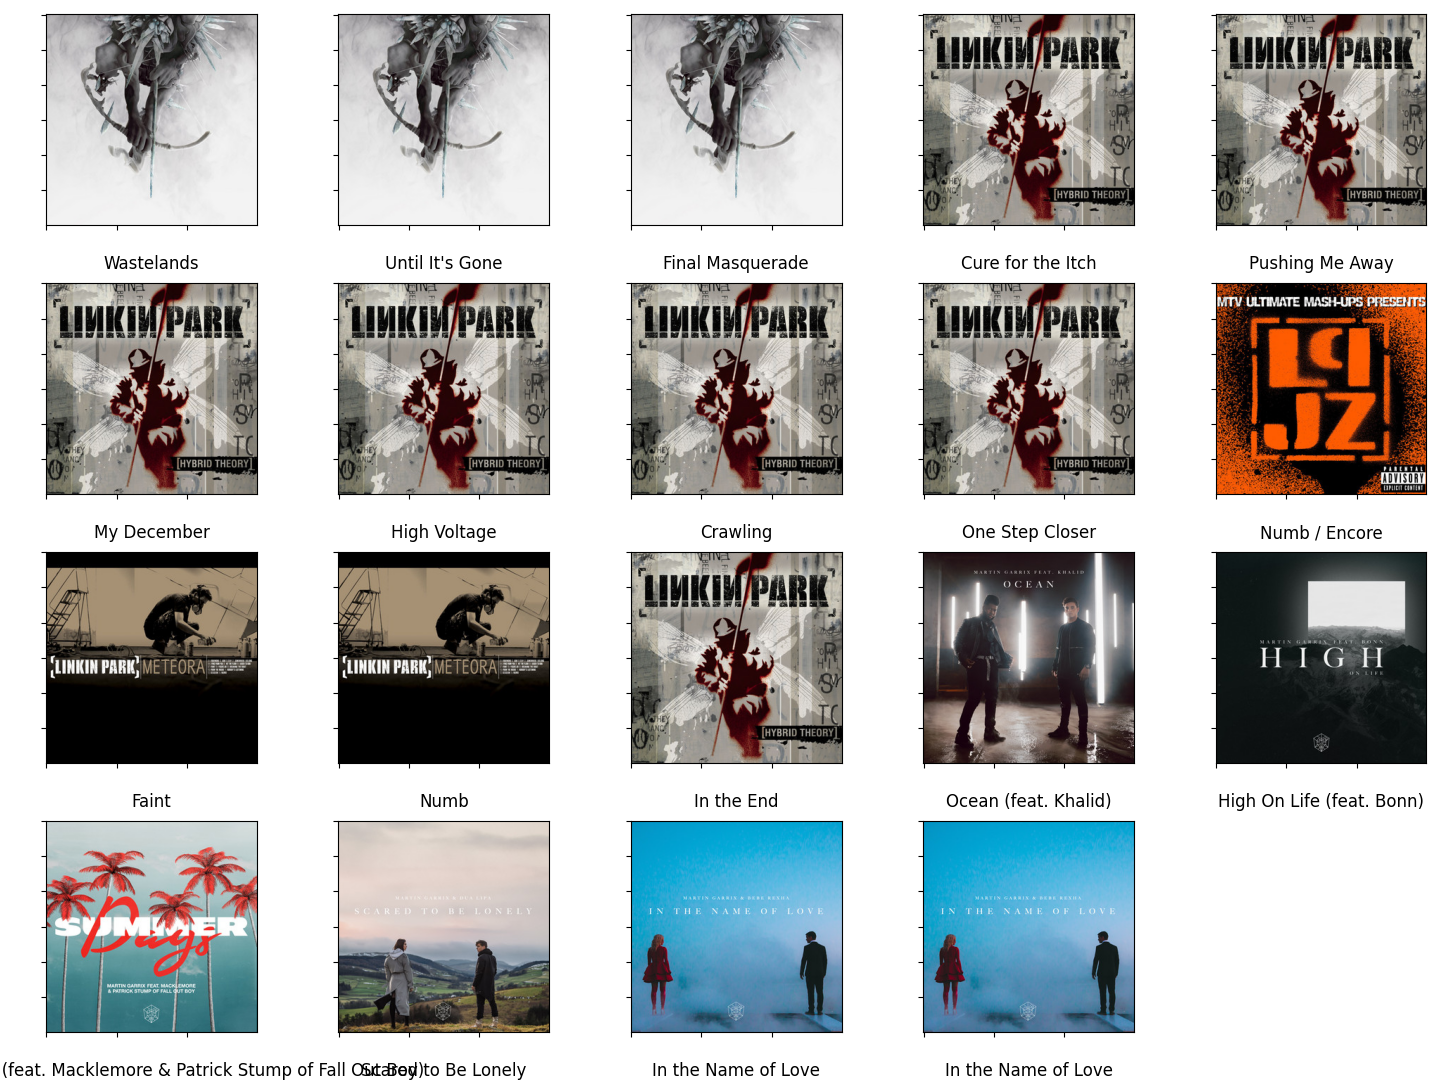

In [285]:
visualize_songs(playlist_metal)

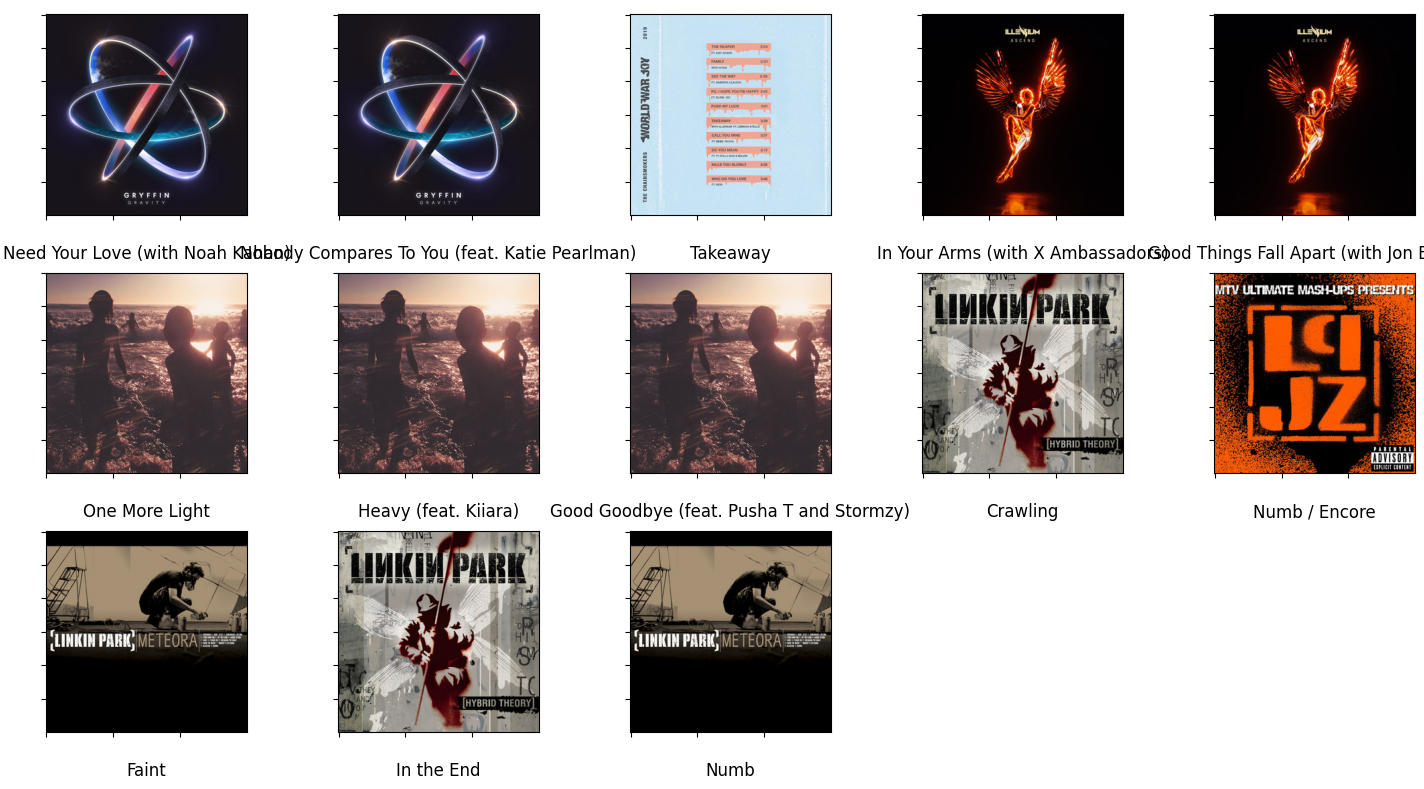

In [286]:
visualize_songs(playlist_dance)

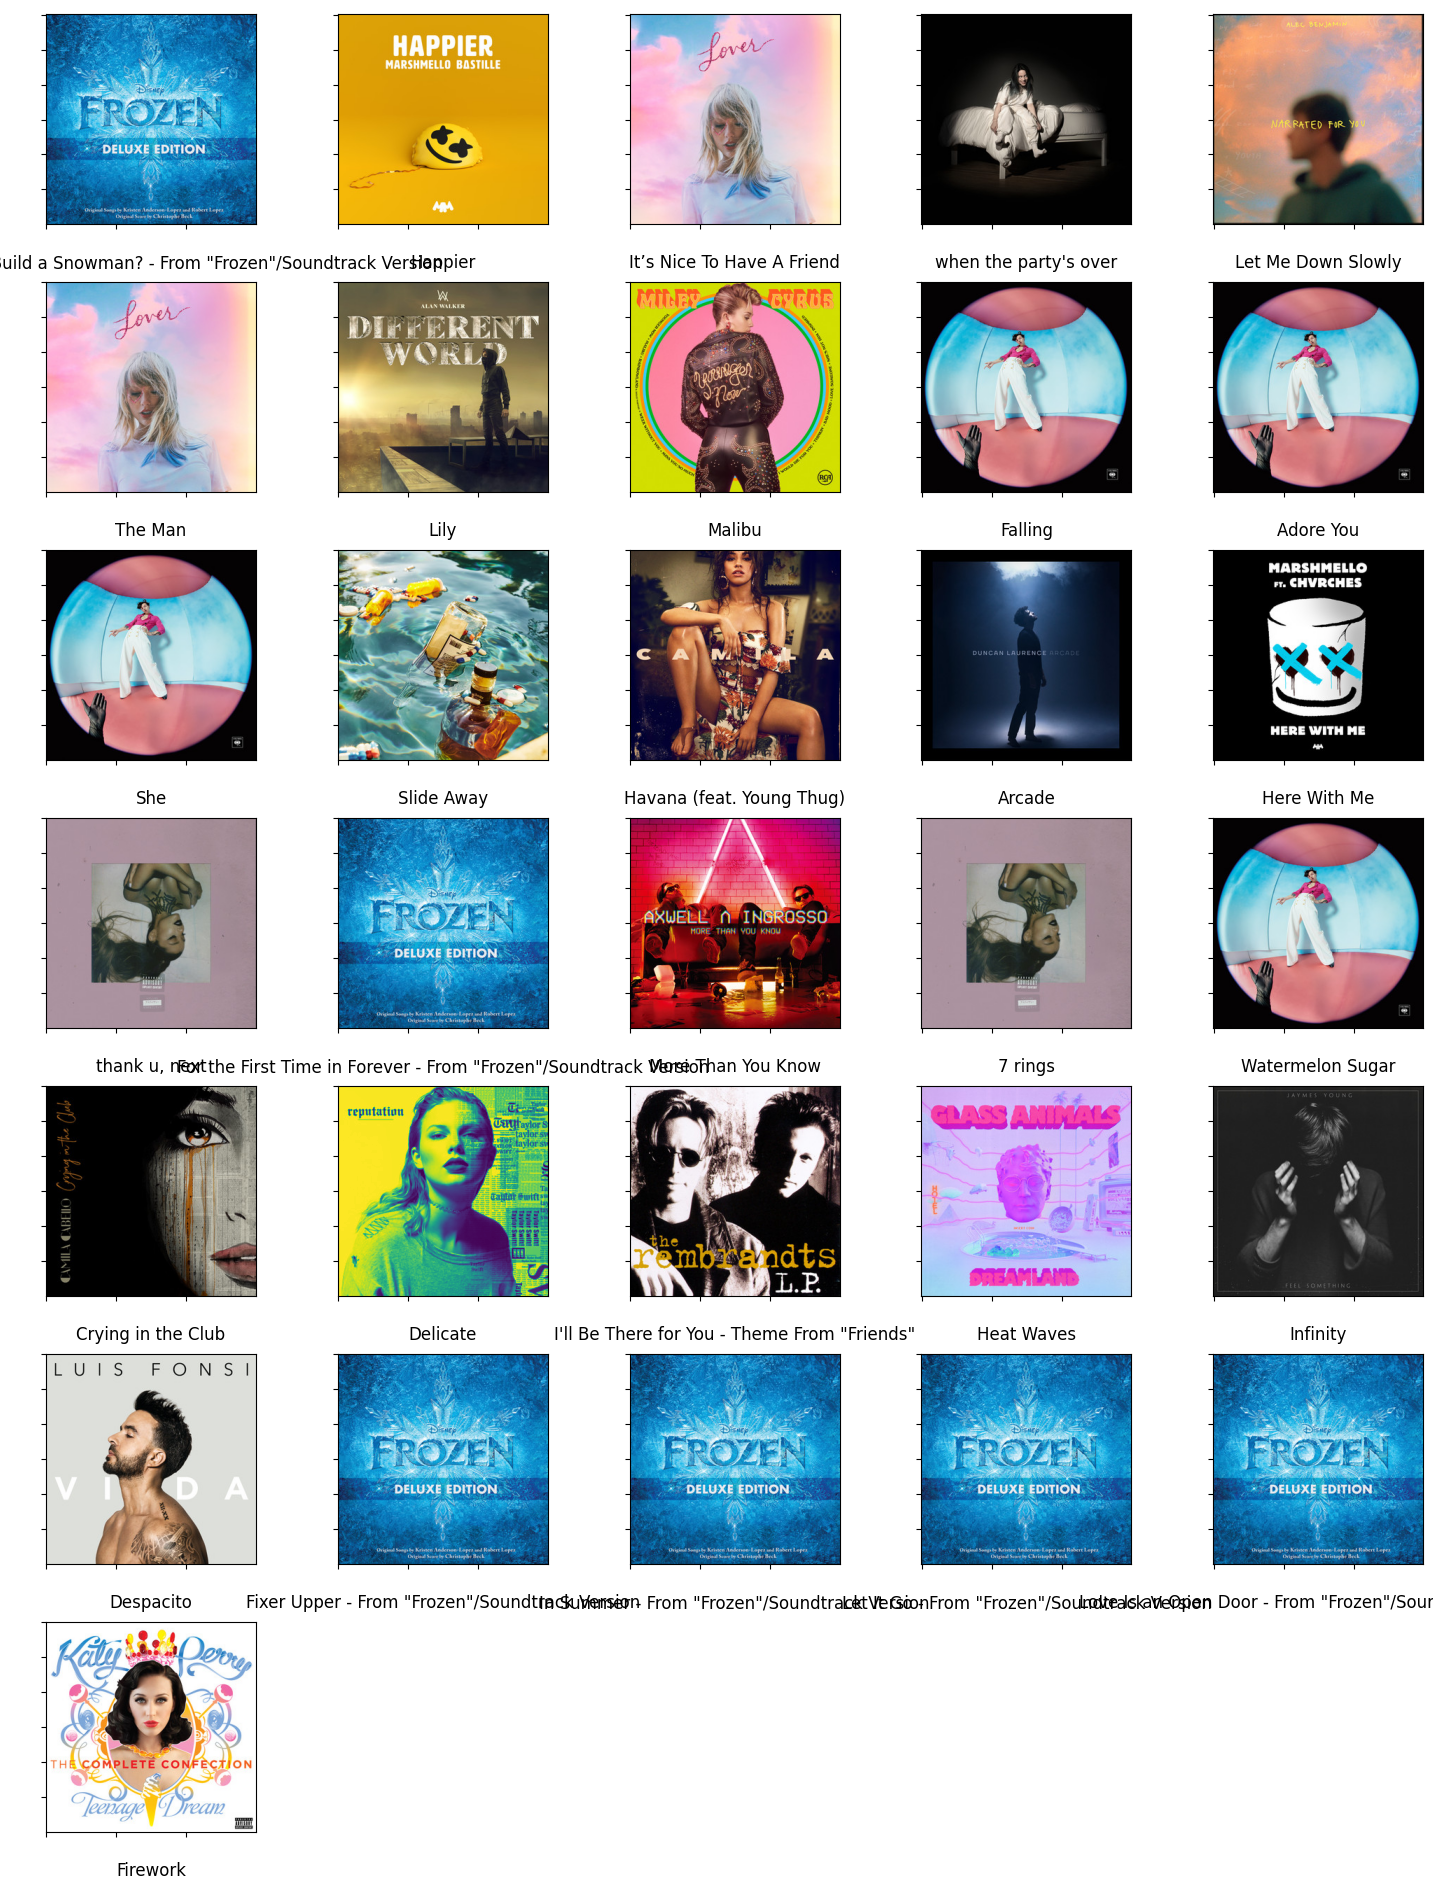

In [287]:
visualize_songs(playlist_sanskar)

## 4. Create Playlist Vector

In [289]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [290]:
complete_feature_set_playlist_vector_metal, complete_feature_set_nonplaylist_metal = generate_playlist_feature(complete_feature_set, playlist_metal, 1.09)


In [291]:
complete_feature_set_playlist_vector_dance, complete_feature_set_nonplaylist_dance = generate_playlist_feature(complete_feature_set, playlist_dance, 1.09)

In [292]:
complete_feature_set_playlist_vector_sanskar, complete_feature_set_nonplaylist_sanskar = generate_playlist_feature(complete_feature_set, playlist_sanskar, 1.09)

In [293]:
complete_feature_set_playlist_vector_metal.shape

(3070,)

In [294]:
complete_feature_set_playlist_vector_dance.shape

(3070,)

In [295]:
complete_feature_set_playlist_vector_sanskar.shape

(3070,)

## 5. Generate Recommendations

![Alt text](image-3.png)

In [296]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [297]:
metal_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_metal, complete_feature_set_nonplaylist_metal)

In [298]:
dance_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_dance, complete_feature_set_nonplaylist_dance)

In [299]:
sanskar_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_sanskar, complete_feature_set_nonplaylist_sanskar)

In [301]:
df_metal = pd.DataFrame(metal_top40)
metal_top40

valence  year  acousticness          artists  danceability   
73777     0.661  2000      0.000220  ['Linkin Park']         0.524  \
73811     0.498  2000      0.013200  ['Linkin Park']         0.615   
73768     0.446  2000      0.014200  ['Linkin Park']         0.636   
73823     0.339  2000      0.017100  ['Linkin Park']         0.544   
73754     0.359  2000      0.003700  ['Linkin Park']         0.421   
73829     0.457  2000      0.014400  ['Linkin Park']         0.603   
73776     0.742  2000      0.000291  ['Linkin Park']         0.474   
73774     0.427  2000      0.030000  ['Linkin Park']         0.512   
102269    0.475  2000      0.000017     ['Godsmack']         0.395   
102243    0.326  2000      0.000072     ['Godsmack']         0.534   
102268    0.653  2000      0.000027     ['Godsmack']         0.483   
102238    0.417  2000      0.000400     ['Godsmack']         0.505   
102232    0.104  2000      0.000553     ['Godsmack']         0.417   
102253    0.089  2000      0.000024     ['Godsmack']         0.419   
102230    0.404  2000      0.000074     ['Godsmack']         0.362   
102271    0.464  2014      0.000039     ['Godsmack']         0.515   
102240    0.335  2014      0.000515     ['Godsmack']         0.499   
73791     0.723  2003      0.007770  ['Linkin Park']         0.535   
73765     0.442  2003      0.000380  ['Linkin Park']         0.451   
73818     0.679  2003      0.001530  ['Linkin Park']         0.488   
73809     0.453  2003      0.042000  ['Linkin Park']         0.466   
73801     0.878  2003      0.062900  ['Linkin Park']         0.740   
102225    0.401  2018      0.000236     ['Godsmack']         0.440   
73785     0.451  2003      0.105000  ['Linkin Park']         0.502   
73790     0.650  2003      0.008530  ['Linkin Park']         0.396   
102266    0.644  2018      0.000198     ['Godsmack']         0.390   
73808     0.542  2003      0.000993  ['Linkin Park']         0.440   
73813     0.537  2003      0.009190  ['Linkin Park']         0.518   
73825     0.581  2003      0.108000  ['Linkin Park']         0.579   
73816     0.315  2003      0.071400  ['Linkin Park']         0.499   
102248    0.306  2003      0.000055     ['Godsmack']         0.529   
73817     0.279  2003      0.062400  ['Linkin Park']         0.545   
102231    0.219  2018      0.056800     ['Godsmack']         0.252   
102249    0.323  2003      0.000027     ['Godsmack']         0.403   
102259    0.226  2003      0.000038     ['Godsmack']         0.310   
102258    0.376  2003      0.000029     ['Godsmack']         0.217   
73767     0.235  2003      0.033600  ['Linkin Park']         0.562   
102246    0.370  2004      0.158000     ['Godsmack']         0.541   
73826     0.596  2007      0.114000  ['Linkin Park']         0.529   
102229    0.272  2004      0.006610     ['Godsmack']         0.553   

        duration_ms  energy  explicit                      id   
73777        184867   0.939         0  1Vej0qeQ3ioKwpI6FUbRv1  \
73811        194427   0.947         0  7kxM3UJwN6rHAW5kwdlAHK   
73768        183973   0.884         0  6xtQ23d8GEXgcxyUKPtwc5   
73823        189800   0.935         0  6UzeOH4bRPzKTo2wCXMZmC   
73754        203267   0.978         0  5uuXtfqM7Wp3idCxyHeOll   
73829        184640   0.908         0  5rAxhWcgFng3s570sGO2F8   
73776        189973   0.966         0  5SDOPP5zCdggONUuYWiiTS   
73774        200240   0.970         0  5egqKwgK5r5rvGD1LrtR7J   
102269       304373   0.756         1  6xXlurslWqFuyqTCBlErzX   
102243       232027   0.901         0  0lM0UP8cjGvrnS25NvFFWc   
102268       255733   0.795         1  4fGmhzoKHK7PFrkhBD55o7   
102238       334893   0.617         0  1losCJa0dcFV6HgZoqEESf   
102232       295733   0.789         1  6gi4VkNXLsl4lAWLU0aOqp   
102253       358627   0.834         0  3vCPApd77OpyntH17SFh6H   
102230       225400   0.847         0  2iKyHlMRUDyOLkBtV30VSI   
102271       226467   0.950         1  2DpLoT8qfJdZhsLGFg413r   
102240       282200   0.882     

In [300]:
df_dance = pd.DataFrame(dance_top40)
dance_top40
# energy, duration,speechiness, tempo, danceability, acousticness

valence  year  acousticness          artists  danceability   
73829     0.457  2000      0.014400  ['Linkin Park']         0.603  \
73777     0.661  2000      0.000220  ['Linkin Park']         0.524   
73825     0.581  2003      0.108000  ['Linkin Park']         0.579   
73774     0.427  2000      0.030000  ['Linkin Park']         0.512   
73801     0.878  2003      0.062900  ['Linkin Park']         0.740   
73811     0.498  2000      0.013200  ['Linkin Park']         0.615   
102269    0.475  2000      0.000017     ['Godsmack']         0.395   
73765     0.442  2003      0.000380  ['Linkin Park']         0.451   
73768     0.446  2000      0.014200  ['Linkin Park']         0.636   
73791     0.723  2003      0.007770  ['Linkin Park']         0.535   
102258    0.376  2003      0.000029     ['Godsmack']         0.217   
73776     0.742  2000      0.000291  ['Linkin Park']         0.474   
73781     0.538  2000      0.001400  ['Linkin Park']         0.492   
73754     0.359  2000      0.003700  ['Linkin Park']         0.421   
73823     0.339  2000      0.017100  ['Linkin Park']         0.544   
73790     0.650  2003      0.008530  ['Linkin Park']         0.396   
73785     0.451  2003      0.105000  ['Linkin Park']         0.502   
73818     0.679  2003      0.001530  ['Linkin Park']         0.488   
73802     0.287  2000      0.105000  ['Linkin Park']         0.593   
73808     0.542  2003      0.000993  ['Linkin Park']         0.440   
73813     0.537  2003      0.009190  ['Linkin Park']         0.518   
73819     0.851  2000      0.163000  ['Linkin Park']         0.750   
73771     0.279  2000      0.000391  ['Linkin Park']         0.484   
73789     0.721  2000      0.375000  ['Linkin Park']         0.730   
73809     0.453  2003      0.042000  ['Linkin Park']         0.466   
73816     0.315  2003      0.071400  ['Linkin Park']         0.499   
73817     0.279  2003      0.062400  ['Linkin Park']         0.545   
102248    0.306  2003      0.000055     ['Godsmack']         0.529   
102268    0.653  2000      0.000027     ['Godsmack']         0.483   
102243    0.326  2000      0.000072     ['Godsmack']         0.534   
102249    0.323  2003      0.000027     ['Godsmack']         0.403   
102259    0.226  2003      0.000038     ['Godsmack']         0.310   
102238    0.417  2000      0.000400     ['Godsmack']         0.505   
73767     0.235  2003      0.033600  ['Linkin Park']         0.562   
102232    0.104  2000      0.000553     ['Godsmack']         0.417   
102230    0.404  2000      0.000074     ['Godsmack']         0.362   
102253    0.089  2000      0.000024     ['Godsmack']         0.419   
102246    0.370  2004      0.158000     ['Godsmack']         0.541   
102229    0.272  2004      0.006610     ['Godsmack']         0.553   
102233    0.270  2004      0.000761     ['Godsmack']         0.478   

        duration_ms  energy  explicit                      id   
73829        184640   0.908         0  5rAxhWcgFng3s570sGO2F8  \
73777        184867   0.939         0  1Vej0qeQ3ioKwpI6FUbRv1   
73825        196907   0.849         0  6n8TMVyFKoUmDc4apxceRD   
73774        200240   0.970         0  5egqKwgK5r5rvGD1LrtR7J   
73801        164213   0.959         0  5VYbLzAplnqPaGNpcf8qhZ   
73811        194427   0.947         0  7kxM3UJwN6rHAW5kwdlAHK   
102269       304373   0.756         1  6xXlurslWqFuyqTCBlErzX   
73765        213933   0.951         0  3agtg0x11wPvLIWkYR39nZ   
73768        183973   0.884         0  6xtQ23d8GEXgcxyUKPtwc5   
73791        175373   0.951         0  3BmjRmFTESgWZLPSVGp8aG   
102258       246040   0.920         0  44NRdYQw7P0GWuiunRv3hr   
73776        189973   0.966         0  5SDOPP5zCdggONUuYWiiTS   
73781        157333   0.969         0  3K4HG9evC7dg3N0R9cYqk4   
73754        203267   0.978         0  5uuXtfqM7Wp3idCxyHeOll   
73823        189800   0.935         0  6UzeOH4bRPzKTo2wCXMZmC   
73790        184493   0.974         0  6mqovuFmVj2GFvtqI1Oae5   
73785        178867   0.831     

In [302]:
df_sanskar = pd.DataFrame(sanskar_top40)
sanskar_top40

valence  year  acousticness                            artists   
80983     0.385  2019      0.194000                     ['Katy Perry']  \
82938     0.386  2019      0.662000  ['Julia Michaels', 'Niall Horan']   
27721     0.865  2019      0.012900                   ['Taylor Swift']   
27781     0.564  2019      0.117000                   ['Taylor Swift']   
27777     0.313  2019      0.454000                   ['Taylor Swift']   
61319     0.528  2019      0.004640                    ['Miley Cyrus']   
27739     0.557  2019      0.024600                   ['Taylor Swift']   
82945     0.396  2019      0.458000                 ['Julia Michaels']   
82944     0.408  2019      0.501000                 ['Julia Michaels']   
67658     0.416  2019      0.161000                   ['Madison Beer']   
27789     0.437  2019      0.060000                   ['Taylor Swift']   
27783     0.248  2019      0.781000                   ['Taylor Swift']   
27728     0.487  2019      0.028000                   ['Taylor Swift']   
136478    0.355  2019      0.411000                 ['Camila Cabello']   
136473    0.652  2019      0.016900                 ['Camila Cabello']   
27669     0.714  2019      0.009290                   ['Taylor Swift']   
27735     0.453  2019      0.492000                   ['Taylor Swift']   
98655     0.605  2019      0.618000                   ['Harry Styles']   
27779     0.265  2019      0.808000                   ['Taylor Swift']   
98657     0.860  2019      0.000564                   ['Harry Styles']   
145723    0.591  2019      0.082800                          ['Bazzi']   
145528    0.401  2019      0.175000                     ['Bebe Rexha']   
27802     0.399  2019      0.130000                   ['Taylor Swift']   
54999     0.881  2019      0.019200                        ['Normani']   
27768     0.351  2019      0.736000                   ['Taylor Swift']   
149167    0.643  2019      0.081500                  ['Ariana Grande']   
98654     0.697  2019      0.128000                   ['Harry Styles']   
27753     0.541  2019      0.298000                   ['Taylor Swift']   
27750     0.416  2019      0.008890                   ['Taylor Swift']   
145726    0.554  2019      0.379000                          ['Bazzi']   
136477    0.223  2019      0.906000                 ['Camila Cabello']   
149169    0.569  2019      0.026800                  ['Ariana Grande']   
98670     0.411  2019      0.615000                   ['Harry Styles']   
98672     0.700  2019      0.328000                   ['Harry Styles']   
65801     0.164  2019      0.005480  ['Mark Ronson', 'Camila Cabello']   
54341     0.469  2019      0.602000                 ["Olivia O'Brien"]   
149194    0.470  2019      0.451000                  ['Ariana Grande']   
149157    0.331  2019      0.173000                  ['Ariana Grande']   
27851     0.257  2019      0.069200                     ['Tate McRae']   
98664     0.254  2019      0.210000                   ['Harry Styles']   

        danceability  duration_ms  energy  explicit                      id   
80983          0.770       223523   0.882         0  5PYQUBXc7NYeI1obMKSJK0  \
82938          0.518       173307   0.467         0  5WtfUKzXircvW8l5aaVZWT   
27721          0.811       222400   0.719         0  4y5bvROuBDPr5fuwXbIBZR   
27781          0.552       178427   0.702         0  1BxfuPKGuaTgP7aM0Bbdwr   
27777          0.712       198533   0.732         0  2dgFqt3w9xIQRjhPtwNk3D   
61319          0.681       219080   0.865         1  2WyRfGeHo97VC5mP1BBSzr   
27739          0.695       190240   0.710         0  1LLXZFeAHK9R4xUramtUKw   
82945          0.774       182800   0.466         0  0ND8rF8oirMXtE59n585P6   
82944          0.646       183720   0.485         1  5AmTHXOp1sTFkYZBRBQ7zt   
67658          0.650       179577   0.594         0  0L1IszgjzIZRBENyHJTQms   
27789          0.598       228027   0.680         0  2mvabkN1i2gLnGAPUVdwek   
27783          0.824     

In [306]:
from sklearn.preprocessing import MinMaxScaler

# DataFrames
df1 = pd.DataFrame(df_metal)
df2 = pd.DataFrame(df_dance)
df3 = pd.DataFrame(df_sanskar)

fmap = ["energy", "speechiness", "tempo", "danceability", "acousticness", "energy", "loudness"]
# Select columns
selected_columns_df1 = df1[fmap]
selected_columns_df2 = df2[fmap]
selected_columns_df3 = df3[fmap]

# Normalize the selected columns to ensure they are in the same range (0 to 1)
scaler = MinMaxScaler()
selected_columns_df1_normalized = scaler.fit_transform(selected_columns_df1)
selected_columns_df3_normalized = scaler.transform(selected_columns_df3)

# Calculate cosine similarity between the normalized selected columns
similarity_matrix = cosine_similarity(selected_columns_df1_normalized, selected_columns_df3_normalized)

# The similarity_matrix will be a NumPy array where each element (i, j) represents
# the cosine similarity between the selected columns of row i in df1 and row j in df2
print(similarity_matrix)

# Calculate the mean similarity score as a single percentage value
mean_similarity = (similarity_matrix.mean() + 1) * 50

# The mean_similarity represents the overall similarity between the two DataFrames
print(f"Mean Similarity: {mean_similarity:.2f}%")


[[0.7078167  0.01616717 0.68640802 ... 0.36672913 0.37285243 0.65222054]
 [0.78602406 0.05600634 0.75994714 ... 0.39615132 0.46604052 0.66006912]
 [0.81546909 0.08636509 0.83549541 ... 0.45682822 0.54700744 0.66771571]
 ...
 [0.94489956 0.66638954 0.64211146 ... 0.80334965 0.59979224 0.96368677]
 [0.90069863 0.38368289 0.65199029 ... 0.5932993  0.49311486 0.89092019]
 [0.80360258 0.11972475 0.95479112 ... 0.54593784 0.72732817 0.58350342]]
Mean Similarity: 68.73%
